In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [2]:
# #############################################################################
# Get data
from superdarn_cluster.dbtools import flatten_data_11_features, read_db
import datetime as dt

start_time = dt.datetime(2018, 2, 7, 12)
end_time = dt.datetime(2018, 2, 7, 20)
rad = 'sas'
db_path = "./Data/sas_GSoC_2018-02-07.db"
b = 0
data_dict = read_db(db_path, rad, start_time, end_time)
data_flat_unscaled = flatten_data_11_features(data_dict, remove_close_range=True)

In [3]:
import sklearn
sklearn.__version__

'0.15.0'

In [4]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
feature_names = ['beam', 'gate', 'vel', 'wid', 'power', 'freq', 'time', 'phi0', 'elev', 'nsky', 'nsch']

gate = data_flat_unscaled[:, 1]
power = data_flat_unscaled[:, 4]
beam = data_flat_unscaled[:, 0]
vel = data_flat_unscaled[:, 2]

time = data_flat_unscaled[:, 6]
#time = (time - np.floor(time)) * 24 * 60 * 60 / secs_per_measurement

#plt.scatter(time, gate)
#plt.show()

#plt.scatter(time, power)
#plt.show()




2.856995165348053
-0.0004671592970142413
-0.0870198159939295
-0.21956458180607408


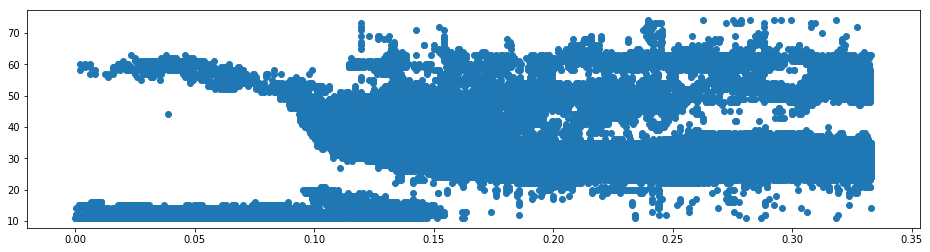

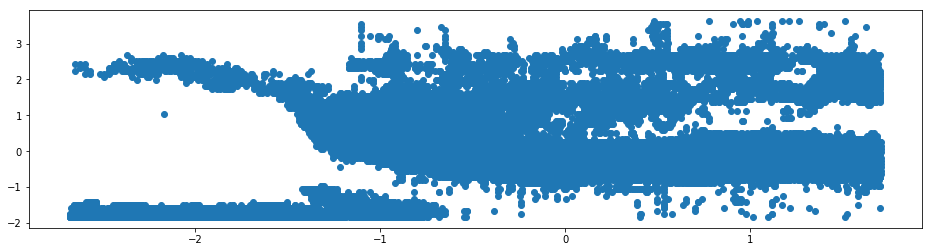

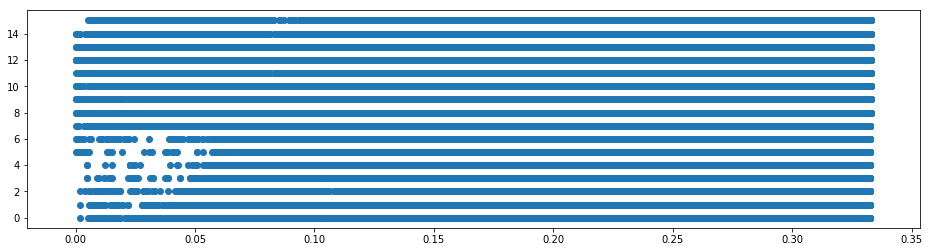

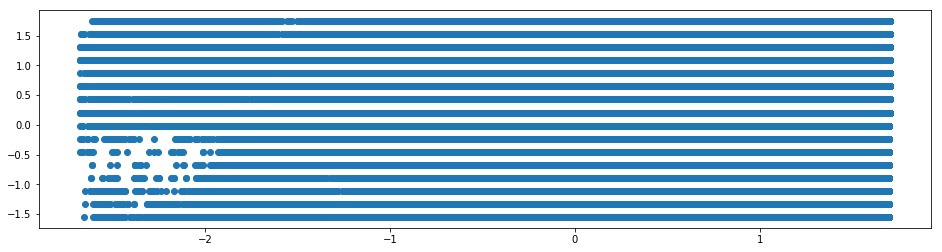

[11. 11. 11. 11. 12. 11. 12. 11. 12. 11. 11. 12. 14. 11. 12. 11. 12. 11.
 11. 11. 11. 11. 12. 11. 12. 11. 12. 14. 11. 12. 14. 11. 12. 11. 11. 11.
 11. 11. 12. 11. 11. 11. 14. 15. 11. 12. 14. 15. 11. 12. 58. 11. 60. 11.
 11. 11. 11. 11. 14. 15. 11. 14. 15. 11. 11. 11. 11. 11. 11. 14. 15. 14.
 15. 11. 12. 11. 11. 12. 11. 11. 11. 11. 11. 14. 11. 14. 11. 59. 60. 11.
 11. 11. 12. 13. 11. 12. 11. 11. 14. 15.]
[-1.84442076 -1.84442076 -1.84442076 -1.84442076 -1.75740095 -1.84442076
 -1.75740095 -1.84442076 -1.75740095 -1.84442076 -1.84442076 -1.75740095
 -1.58336131 -1.84442076 -1.75740095 -1.84442076 -1.75740095 -1.84442076
 -1.84442076 -1.84442076 -1.84442076 -1.84442076 -1.75740095 -1.84442076
 -1.75740095 -1.84442076 -1.75740095 -1.58336131 -1.84442076 -1.75740095
 -1.58336131 -1.84442076 -1.75740095 -1.84442076 -1.84442076 -1.84442076
 -1.84442076 -1.84442076 -1.75740095 -1.84442076 -1.84442076 -1.84442076
 -1.58336131 -1.4963415  -1.84442076 -1.75740095 -1.58336131 -1.4963415
 -1.844420

In [28]:
# What matters for scaling this is the size of each step between these (discrete) measurements.
# If you want to connect things within 1 range gate and 1 beam, do no scaling and set eps ~= 1.1
# If you want to connect things within 6 time measurements, scale it so that 6 * dt = 1 and eps ~= 1.1
# Time has some gaps in between each scan of 16 beams, so epsilon should be large enough

time = time - time[0]
scaled_time = time * 0.000467 #(time - np.floor(time)) * 24 * 60 * 60 
uniq_time = np.sort(np.unique(scaled_time))
shifted_time = np.roll(uniq_time, -1)
dt = np.min((shifted_time - uniq_time)[:-1])
scaled_time = scale(scaled_time / (dt))
print(dt)
# Divide by variance and center mean at 0
scaled_gate = gate * 0.087 #scale(gate)
scaled_beam = beam * 0.22
# Do a minmax scale here. This way, epsilon = 0.1 represents a 10% change in value.
#scaled_beam = (time - np.min(beam)) / (np.max(beam) - np.min(beam))

sorted_time = np.sort(np.unique(scaled_time))[:20]
print(sorted_time[0] - sorted_time[1])

sorted_gate = np.sort(np.unique(scaled_gate))[:10]
print(sorted_gate[0] - sorted_gate[1])


sorted_beam = np.sort(np.unique(scaled_beam))[:10]
print(sorted_beam[0] - sorted_beam[1])

plt.figure(figsize=(16,4))
plt.scatter(time, gate)
plt.show()
plt.figure(figsize=(16,4))
plt.scatter(scaled_time, scaled_gate)
plt.show()

plt.figure(figsize=(16,4))
plt.scatter(time, beam)
plt.show()
plt.figure(figsize=(16,4))
plt.scatter(scaled_time, scaled_beam)
plt.show()


print(gate[:100])
print(scaled_gate[:100])

print()
print(beam[:100])
print(scaled_beam[:100])
print(scaled_beam[0] - scaled_beam[1])

print()
print(time[:100])

print(scaled_time[:100])

In [11]:
X = np.column_stack((scaled_time, scaled_gate))
print(X.shape)
plt.close()

(71649, 2)


In [12]:
# #############################################################################
# Compute DBSCAN
eps, minPts = 1.5, 4
db = DBSCAN(eps=eps, min_samples=minPts).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print(labels[:100])

Estimated number of clusters: 37
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1
  1  1  1  1]


In [14]:
print('Estimated number of clusters: %d' % n_clusters_)
print(labels[:100])

Estimated number of clusters: 37
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1
  1  1  1  1]


In [19]:
print(scale(np.array(range(16)).astype(float)))
print(scale(np.array(range(76)).astype(float)))

[-1.62697843 -1.41004798 -1.19311752 -0.97618706 -0.7592566  -0.54232614
 -0.32539569 -0.10846523  0.10846523  0.32539569  0.54232614  0.7592566
  0.97618706  1.19311752  1.41004798  1.62697843]
[-1.70940865 -1.66382442 -1.61824019 -1.57265596 -1.52707172 -1.48148749
 -1.43590326 -1.39031903 -1.3447348  -1.29915057 -1.25356634 -1.20798211
 -1.16239788 -1.11681365 -1.07122942 -1.02564519 -0.98006096 -0.93447673
 -0.8888925  -0.84330827 -0.79772404 -0.7521398  -0.70655557 -0.66097134
 -0.61538711 -0.56980288 -0.52421865 -0.47863442 -0.43305019 -0.38746596
 -0.34188173 -0.2962975  -0.25071327 -0.20512904 -0.15954481 -0.11396058
 -0.06837635 -0.02279212  0.02279212  0.06837635  0.11396058  0.15954481
  0.20512904  0.25071327  0.2962975   0.34188173  0.38746596  0.43305019
  0.47863442  0.52421865  0.56980288  0.61538711  0.66097134  0.70655557
  0.7521398   0.79772404  0.84330827  0.8888925   0.93447673  0.98006096
  1.02564519  1.07122942  1.11681365  1.16239788  1.20798211  1.25356634
  

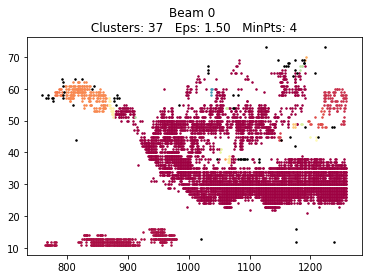

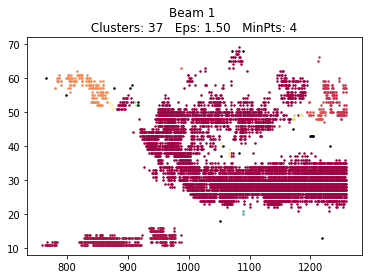

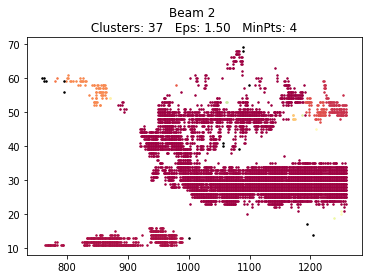

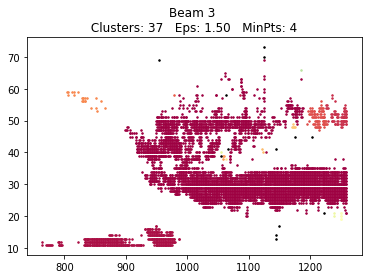

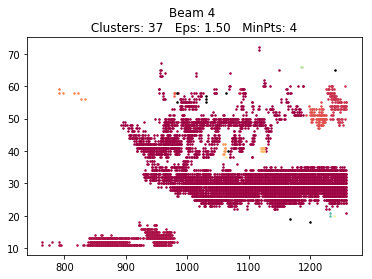

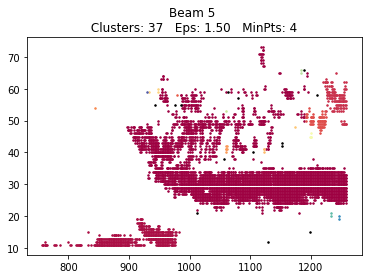

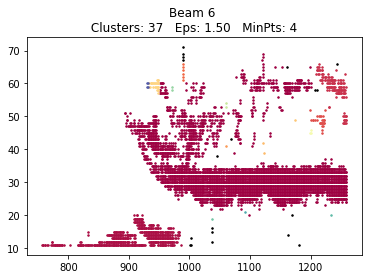

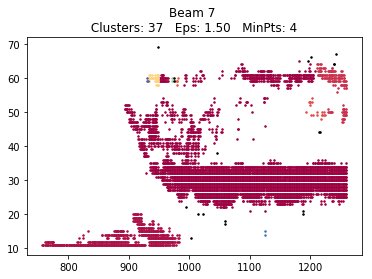

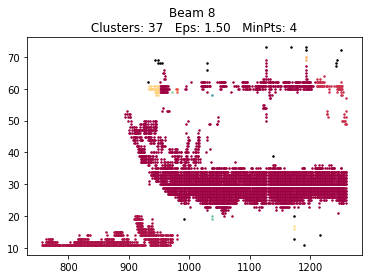

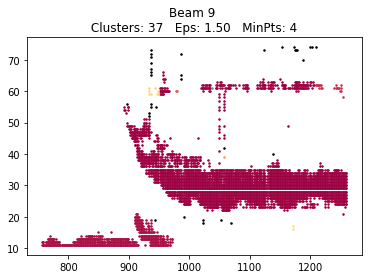

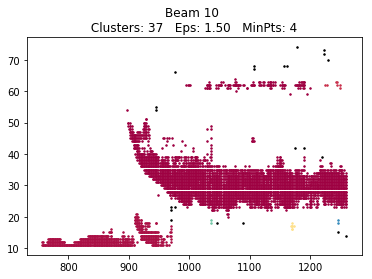

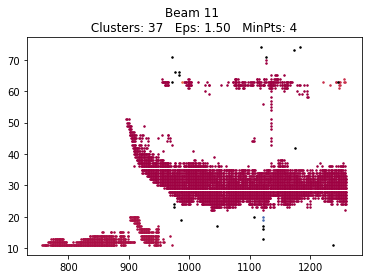

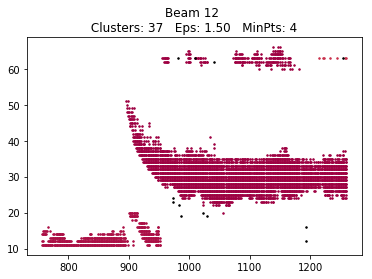

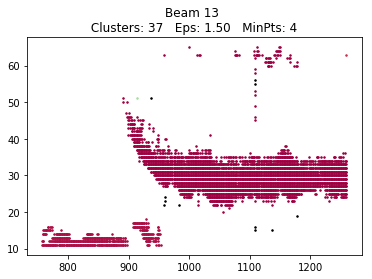

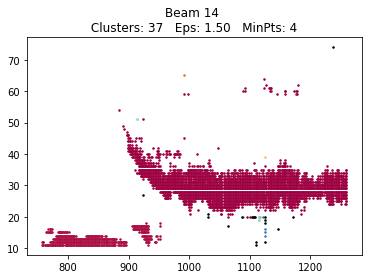

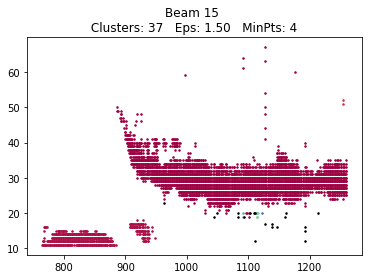

In [15]:
# #############################################################################
# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
range_max = data_dict['nrang'][0]

for b in range(16):
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        #fig, ax = plt.figure(figsize=(16, 8))

        class_member_mask = (labels == k)
        beam_mask = (beam == b)

        xy = X[class_member_mask & core_samples_mask & beam_mask]
        plt.plot(xy[:, 0], xy[:, 1], '.', color=tuple(col), markersize=3)

        xy = X[class_member_mask & ~core_samples_mask & beam_mask]
        plt.plot(xy[:, 0], xy[:, 1], '.', color=tuple(col), markersize=3)

    #plt.xlim((np.min(time), np.max(time)))
    #plt.ylim((0, range_max))
    plt.title('Beam %d \n Clusters: %d   Eps: %.2f   MinPts: %d ' % (b, n_clusters_, eps, minPts))
    plt.show()
    #plt.savefig('sas beam ' + str(b) + ' dbscan clusters.png')
    #plt.close()


In [21]:
from superdarn_cluster.utilities import plot_clusters

stats_i = [0, 1, 2, 3, 4, 7, 8]
data_flat_unscaled[:, 2] = np.abs(data_flat_unscaled[:, 2])
data_flat_unscaled[:, 2] = np.abs(data_flat_unscaled[:, 2])

plot_clusters(labels, data_flat_unscaled[:, stats_i], data_flat_unscaled[:, 6], 
               gate, vel, np.array(feature_names)[stats_i], range_max, start_time, end_time, save=True)